# Import libraries

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras import backend as K
from sklearn.metrics import confusion_matrix
from PIL import Image
import pandas as pd
import time
import json
import numpy as np
import glob
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/carolina/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/carolina/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/carolina/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/carolina/.local/lib/python3.7/site-packages/tensorflo

# Train with data_final:

In [2]:
data_final = pd.read_pickle('../OUTPUT/data_final.pkl')

In [3]:
print(data_final.shape)
data_final.head()

(13809, 13)


,label,image_path,image_name,arrays,0-2,4-6,8-12,15-20,21-35,36-45,46-59,60-100,gt
0,0-2,../OUTPUT/faces_detected/0-2/image_669.jpg,image_669.jpg,"[[67, 82, 64, 48, 48, 50, 51, 50, 50, 62, 73, ...",1,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,0-2,../OUTPUT/faces_detected/0-2/image_1570.jpg,image_1570.jpg,"[[35, 33, 40, 42, 38, 58, 107, 141, 154, 135, ...",1,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]"
4,0-2,../OUTPUT/faces_detected/0-2/image_1055.jpg,image_1055.jpg,"[[21, 15, 17, 18, 17, 20, 17, 14, 16, 19, 23, ...",1,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]"
5,0-2,../OUTPUT/faces_detected/0-2/image_1135.jpg,image_1135.jpg,"[[26, 23, 27, 32, 64, 58, 71, 71, 81, 68, 93, ...",1,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]"
6,0-2,../OUTPUT/faces_detected/0-2/image_231.jpg,image_231.jpg,"[[63, 65, 63, 57, 65, 64, 69, 66, 67, 69, 73, ...",1,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]"


# Split Train and Test:

In [4]:
X = np.stack(data_final['arrays'])
X = X / 255.0 #normalize

In [5]:
y = np.stack(data_final['gt'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11047, 48, 48) (2762, 48, 48) (11047, 8) (2762, 8)


# Adaping the shape to the model:

In [8]:
img_rows, img_cols, img_channels = 48, 48, 1

input_shape= (img_rows, img_cols, img_channels)

num_classes = 8

In [9]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [10]:
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(48, 48 ,1), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

# Compile model

In [11]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
adam = Adam(decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,verbose=1, batch_size=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

# Check score:

In [12]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Accuracy: 69.73%
Test loss: 1.3797288127432346
Test accuracy: 0.6973207592964172


## Comments:

This was the best model after testing with different variables in google colab.

# Confusion Matrix:

[4 4 4 ... 4 1 7]
[5 5 4 ... 5 1 7]


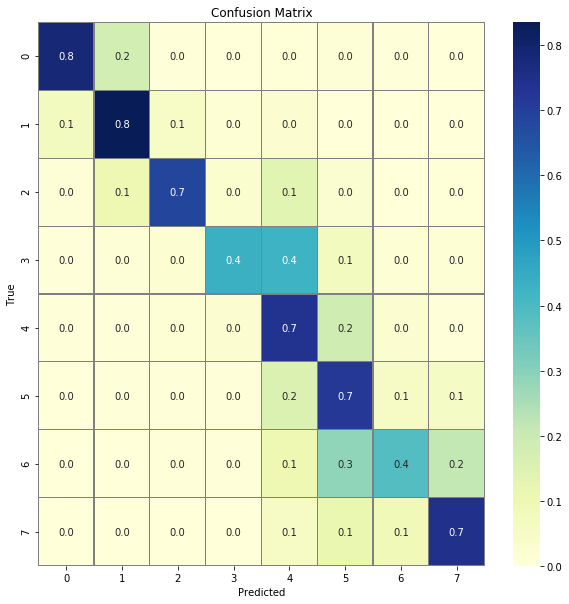

In [13]:
# With normalization:

Y_pred = model.predict(X_test)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 
print(Y_pred_classes)

Y_true = np.argmax(y_test,axis = 1)
print(Y_true)

cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

[4 4 4 ... 4 1 7]
[5 5 4 ... 5 1 7]


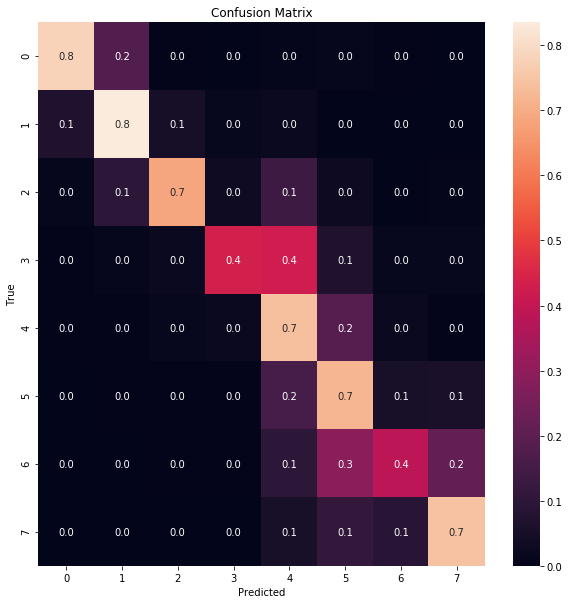

In [14]:
# Without normalization:

Y_pred = model.predict(X_test)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 
print(Y_pred_classes)

Y_true = np.argmax(y_test,axis = 1)
print(Y_true)

cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Model accuracy x Loss

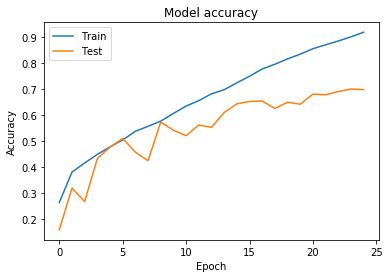

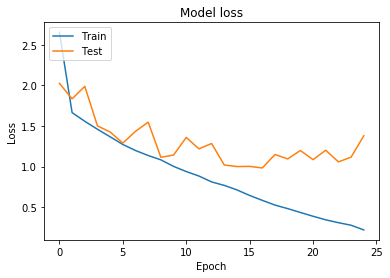

In [15]:
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Save model:

In [ ]:
moment=time.localtime()
name='Model_{}_{}-{}-{}.h5'.format(model.history.history["val_accuracy"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [ ]:
import json

model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name)

All done!